## Time Series Forecasting: Deep Learning Exploration

### Prepare Data

<strong>Refresh Data Preparation Notebook & Variables</strong>

In [ ]:
# Run Data Preperation Notebook
%run -i './Notebook_Scripts/0_Data_Preparation.py'

# Import Stored Variables
%store -r cpi_df gdp_df fedrev_df pce_df fedfunds_df feddebt_df psave_df revolcredit_df unemploy_df infl_df cc_outstanding_df merged_df dataset_dict

print('\nEconomic datasets:')
[print(v) for k, v in dataset_dict.items()]

print('\nmerged_df:')
merged_df.tail()

Stored 'cpi_df' (DataFrame)
Stored 'gdp_df' (DataFrame)
Stored 'fedrev_df' (DataFrame)
Stored 'pce_df' (DataFrame)
Stored 'fedfunds_df' (DataFrame)
Stored 'feddebt_df' (DataFrame)
Stored 'psave_df' (DataFrame)
Stored 'revolcredit_df' (DataFrame)
Stored 'unemploy_df' (DataFrame)
Stored 'infl_df' (DataFrame)
no stored variable or alias cc_outstanding_df
no stored variable or alias merged_df
no stored variable or alias dataset_dict

Economic datasets:
cpi_df
gdp_df
fedrev_df
pce_df
fedfunds_df
feddebt_df
psave_df
revolcredit_df
unemploy_df
infl_df

merged_df:
UsageError: Unknown variable 'cc_outstanding_df'


,DATE,CPI,GDP,FEDREV_mm_nom,PCE,FEDFUNDS,GFDEBTN,PSAVERT,REVOLSL,UNRATE,INFL
936,2023-08-01,306.269,NaN,NaN,18689.9,5.33,NaN,4.2,1288.12390,3.8,3.707504
937,2023-09-01,307.481,NaN,NaN,18823.4,5.33,NaN,3.7,1292.56745,3.8,3.689903
938,2023-10-01,307.619,NaN,NaN,18864.7,5.33,NaN,3.8,1295.44619,3.9,3.232356
939,2023-11-01,NaN,NaN,NaN,NaN,5.33,NaN,NaN,NaN,NaN,NaN
940,2024-01-01,NaN,NaN,5036380.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<strong>Import Libraries</strong>

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn
import dateutil.relativedelta
from dateutil import relativedelta
import datetime
import math
import seaborn as sns
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.dates as mdates
from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

2023-12-14 03:41:06.510373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 03:41:06.622400: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-14 03:41:06.626895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-14 03:41:06.626912: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

### Create War Dataframe

In [ ]:
def war_df(df, start_date, end_date, cutoff_date=None, lag_pre=0, lag_post=0):

    # Calculate War Period & Dates
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')

    war_period = relativedelta.relativedelta(end_date, start_date)

    lag_pre = start_date - dateutil.relativedelta.relativedelta(years=lag_pre)
    lag_post = end_date + dateutil.relativedelta.relativedelta(years=lag_post)

    # Create War Dataframe
    df_all = df.loc[(df.DATE >= lag_pre.strftime('%Y-%m-%d')) & (df.DATE <= lag_post.strftime('%Y-%m-%d'))]

    # War Status
    df_all.loc[df.DATE < start_date.strftime('%Y-%m-%d'),'Status'] = 'pre'
    df_all.loc[df.DATE > end_date.strftime('%Y-%m-%d'),'Status'] = 'post'
    df_all.loc[(df.DATE >= start_date.strftime('%Y-%m-%d')) & (df.DATE <= end_date.strftime('%Y-%m-%d')),'Status'] = 'during'

    # War Train Test
    train_test_split = 0.25

    if cutoff_date is not None:
        cutoff_date = datetime.datetime.strptime(cutoff_date, '%Y-%m-%d')
        df_all.loc[df.DATE < cutoff_date.strftime('%Y-%m-%d'),'Train_Test'] = 'train'
        df_test_count = math.ceil(len(df_all[df_all.Train_Test=='train'])*train_test_split)
        df_all = df_all.reset_index(drop=True)
        df_all.loc[df_test_count*3:(df_test_count*4)-1,'Train_Test'] = 'test'
    else:
        df_all.loc[df.DATE < start_date.strftime('%Y-%m-%d'),'Train_Test'] = 'train'
        df_test_count = math.ceil(len(df_all[df_all.Train_Test=='train'])*train_test_split)
        df_all = df_all.reset_index(drop=True)
        df_all.loc[df_test_count*3:(df_test_count*4)-1,'Train_Test'] = 'test'

    return df_all

In [ ]:
# Separate DataFrame for Model Training
def war_cutoff_df(df):

    cutoff_index = np.where(df.Train_Test=='cutoff')[0][0]
    df_cutoff = df.iloc[:cutoff_index]

    return df_cutoff

## Vietnam War

In [ ]:
# Create War Dataframe
vietnam_war_df = war_df(merged_df, '1955-11-01', '1975-04-30', lag_pre=10, lag_post=10)
vietnam_war_df

,DATE,CPI,GDP,FEDREV_mm_nom,PCE,FEDFUNDS,GFDEBTN,PSAVERT,REVOLSL,UNRATE,INFL,Status,Train_Test
0,1946-01-01,NaN,NaN,39296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pre,train
1,1947-01-01,21.48,243.164,38514.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pre,train
2,1947-02-01,21.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pre,train
3,1947-03-01,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pre,train
4,1947-04-01,22.00,245.968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pre,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,1984-12-01,105.50,NaN,NaN,2582.6,8.38,NaN,11.1,100.38563,7.3,4.043393,post,NaN
457,1985-01-01,105.70,4230.168,734037.0,2618.8,8.35,1710731.0,10.2,102.84183,7.3,3.525955,post,NaN
458,1985-02-01,106.30,NaN,NaN,2640.8,8.50,NaN,8.9,105.34046,7.2,3.606238,post,NaN
459,1985-03-01,106.80,NaN,NaN,2648.5,8.58,NaN,8.6,107.95035,7.2,3.790087,post,NaN


### Average Economic Measures

In [ ]:
# Taking desired economic measures and converting them to an averaged quarterly number to use with 
# quarterly GDP
def quarterly_economic_measures(df,EM,index_start,index_end):
    counter = 0
    econ_value = 0
    averaged_values = []
    for i in range(index_start,index_end+1):
        counter += 1
        econ_value += df.loc[i][EM]
        if counter % 3 == 0:
            averaged_values.append(round(econ_value/3,2))
            econ_value = 0
    return averaged_values

### Economic Measures to Average

Only a few of our economic measures have data during our Vietnam War time period so we are going to only keep the ones that have data we can use to average and work alongside GDP

In [ ]:
EM_df = vietnam_war_df[['CPI','UNRATE','INFL']]
EM_list = list(EM_df.columns)
EM_df

,CPI,UNRATE,INFL
0,NaN,NaN,NaN
1,21.48,NaN,NaN
2,21.62,NaN,NaN
3,22.00,NaN,NaN
4,22.00,NaN,NaN
...,...,...,...
456,105.50,7.3,4.043393
457,105.70,7.3,3.525955
458,106.30,7.2,3.606238
459,106.80,7.2,3.790087


### Build DataFrame with Averaged Economic Measures

Create a dataframe for the given time period that takes monthly economic metrics and averages them for a quarterly score to use with quarterly GDP values

In [ ]:
def build_df(df,EM_list,index_start,index_end):    
    EM_header = []
    EM_column = []
    for EM in EM_list:
        EM_header.append(EM)
        EM_column.append(quarterly_economic_measures(df,EM,index_start,index_end))
    df = pd.DataFrame()
    for i in range(len(EM_header)):
        df[EM_header[i]] = EM_column[i]
    return df

In [ ]:
# We want 3 month averages for our chosen economic measures, 'CPI', 'INFL', and 'UNRATE'
# 'INFL' and 'UNRATE' don't have values until index 13, but we need 3 months so we use index 14 as our
# starting index and 460 (end of the dataframe) for our ending index

vw_aem_df = build_df(vietnam_war_df,EM_list,14,460)
gdp_list = list(vietnam_war_df[vietnam_war_df['GDP'].notnull()]['GDP'])
date_list = list(vietnam_war_df[vietnam_war_df['GDP'].notnull()]['DATE'])

# We need the 'GDP' entries by date to match the 3 averaged economic measures, so we remove the first 
# 6 'GDP' values to line up with dates.
gdp_list = gdp_list[5:]
date_list = date_list[5:]

# Vietnam War Averaged Economic Measures Dataframe
vw_aem_df['GDP'] = gdp_list
vw_aem_df['DATE'] = date_list
vw_aem_df

,CPI,UNRATE,INFL,GDP,DATE
0,23.66,3.90,8.19,272.567,1948-04-01
1,24.19,3.57,9.51,279.196,1948-07-01
2,24.37,3.80,7.28,280.366,1948-10-01
3,24.07,4.03,2.97,275.034,1949-01-01
4,23.91,5.00,1.06,271.351,1949-04-01
...,...,...,...,...,...
144,102.93,7.77,4.71,4009.601,1984-04-01
145,103.77,7.37,4.32,4084.250,1984-07-01
146,104.73,7.40,4.28,4148.551,1984-10-01
147,105.50,7.27,3.91,4230.168,1985-01-01


### Pre-Vietnam War Data

In [ ]:
# Creating a dataframe for Pre-Vietnam War
PVW_df = vw_aem_df[vw_aem_df['DATE']< '1955-11-01']
PVW_df

,CPI,UNRATE,INFL,GDP,DATE
0,23.66,3.90,8.19,272.567,1948-04-01
1,24.19,3.57,9.51,279.196,1948-07-01
2,24.37,3.80,7.28,280.366,1948-10-01
3,24.07,4.03,2.97,275.034,1949-01-01
4,23.91,5.00,1.06,271.351,1949-04-01
5,23.84,6.33,-1.41,272.889,1949-07-01
6,23.71,7.10,-2.71,270.627,1949-10-01
7,23.61,6.50,-1.94,280.828,1950-01-01
8,23.63,6.17,-1.17,290.383,1950-04-01
9,23.91,5.30,0.27,308.153,1950-07-01


### GDP Actuals Prior to Vietnam War

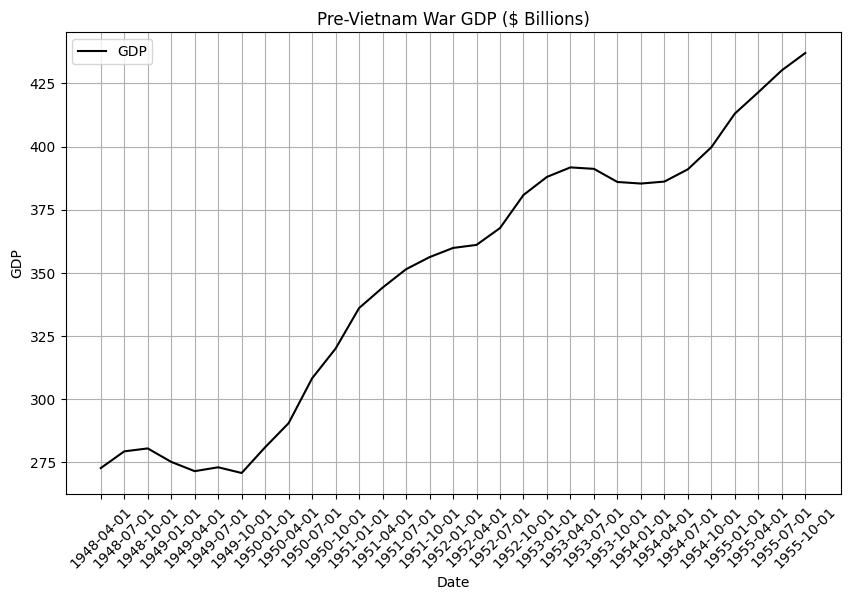

In [ ]:
# Plot Train, Test
plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(PVW_df.DATE, PVW_df.GDP, color='black', label='GDP')
plt.xticks(rotation=45)
plt.title('Pre-Vietnam War GDP ($ Billions)')
plt.legend()
plt.grid(True)
plt.show()

### 

### Correlation Matrix

In [ ]:
# Correlation Matrix for 'CPI', 'UNRATE', 'INFL'
PVW_df.corr()

,CPI,UNRATE,INFL,GDP
CPI,1.000000,-0.447806,-0.098891,0.947339
UNRATE,-0.447806,1.000000,-0.559424,-0.330270
INFL,-0.098891,-0.559424,1.000000,-0.235704
GDP,0.947339,-0.330270,-0.235704,1.000000


### Correlogram

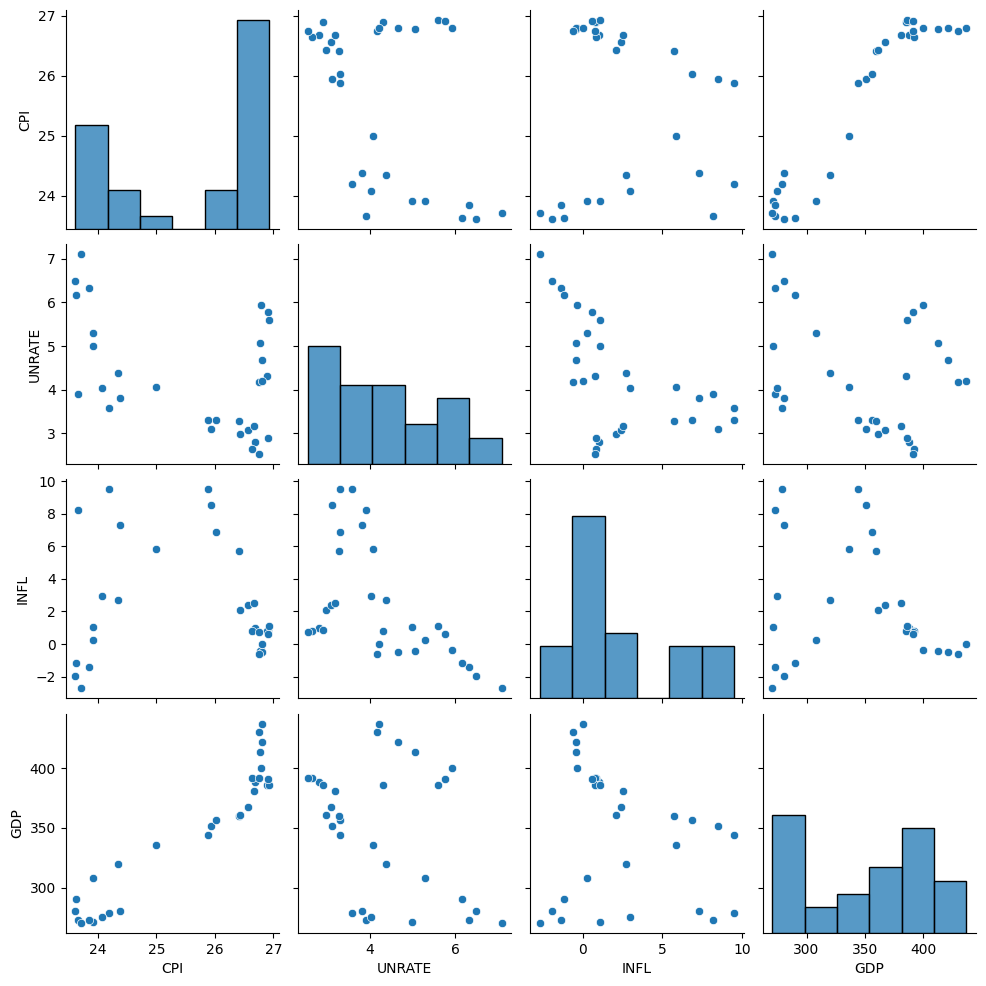

In [ ]:
# Basic correlogram
sns.pairplot(PVW_df)
plt.show()

For this time period the only economic measure that has a good correlation with GDP is CPI, so for the Vietnam War we will be using just CPI and GDP

### Dataframe for our CNN

In [ ]:
CNN_df = PVW_df[['CPI','GDP']]

### Create CNN for Multivariate Multiple Step Sequencing

In [ ]:
 # split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
def cnn_multivariate_gdp(data, steps_out, sequence1, sequence2):
    # define input sequences
    input1 = array(sequence1)
    input2 = array(sequence2)

    # convert to [rows, columns] structure
    input1 = input1.reshape((len(input1), 1))
    input2 = input2.reshape((len(input2), 1))

    # horizontally stack columns
    dataset = hstack((input1, input2))

    # choose a number of time steps
    n_steps_in, n_steps_out = 3, steps_out

    # convert into input/output
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)

    # flatten output
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))

    # number of features
    n_features = X.shape[2]

    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X, y, epochs=7000, verbose=0)

    # prediction
    x_input = array([[input1[-3],input2[-3]], [input1[-2],input2[-2]], [input1[-1],input2[-1]]])
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    results = np.array_split(yhat[0],n_steps_out)

    return results


### Predicting GDP for Vietnam War

We start with the Pre-War data to feed into the CNN and will use this data to learn the sequencing for predictions. Since this model can only predict so many steps in the future we are going to have to predict as many steps as we can, take those results and append them to our dataframe to act as supplemental data that the CNN will then use as data to predict more steps in the future. Essentially we are using predictions to create more predictions, which is a downside of this model, but we're trying to predict about 30 years worth of GDP data. 

In [ ]:
def CNN_GDP_predictions_vietnam_war(full_war_df,CNN_df):
    # The total number of GDP entries we want with Pre-War and Predictions combined
    full_war_gdp_length = len(full_war_df)

    # CPI values
    CPI_list = list(CNN_df.CPI)

    # GDP values
    GDP_list = list(CNN_df.GDP)

    # difference between how many entries we want and how many we currently have
    gdp_difference = full_war_gdp_length - len(GDP_list)

    # maximum number of predictions we can generate from our CNN
    max_predictions = (len(GDP_list) - 3)
    
    # continuously make predictions until we have the desired number
    while gdp_difference != 0:
        # determine how many predictions we will be returning from our CNN
        if gdp_difference > max_predictions:
            num_steps = max_predictions
        else:
            num_steps = gdp_difference

        # make predictions
        predictions = cnn_multivariate_gdp(CNN_df,num_steps,CPI_list,GDP_list)

        # update our values with the new predictions
        for i in range(len(predictions)):
            CPI_list.append(predictions[i][0])
            GDP_list.append(predictions[i][1])
        
        # keep gdp difference up to date    
        gdp_difference = full_war_gdp_length - len(GDP_list)

    # add our predictions to our full war dataframe
    full_war_df['CPI_Predictions'] = CPI_list
    full_war_df['GDP_Predictions'] = GDP_list
    
    
    return full_war_df

In [ ]:
vietnam_war_predictions_df = CNN_GDP_predictions_vietnam_war(vw_aem_df,CNN_df)

2023-12-14 03:41:13.685369: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-14 03:41:13.685405: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-14 03:41:13.685421: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-ba1e4b21-f3e5-4d67-887d-75e6f1b74e8f): /proc/driver/nvidia/version does not exist
2023-12-14 03:41:13.685645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


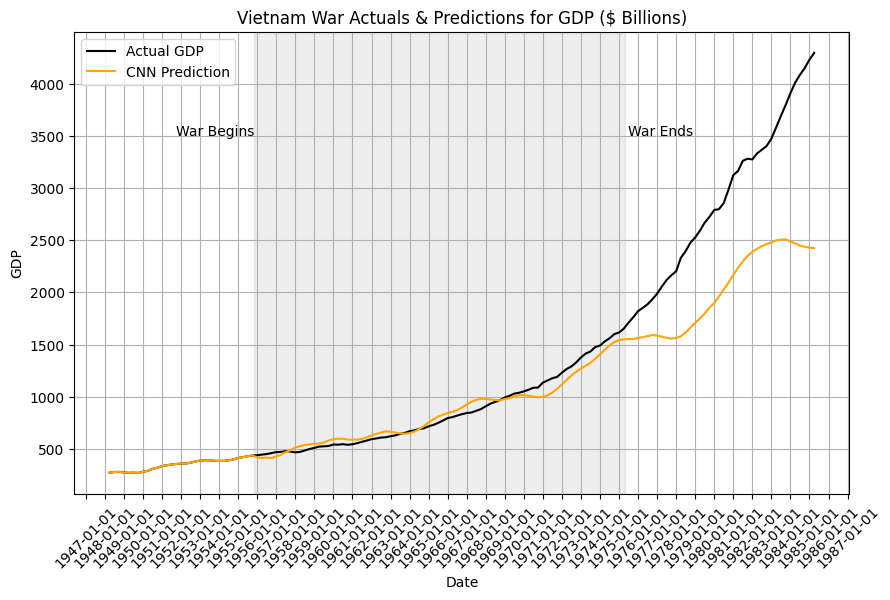

In [ ]:
xdates = [dt.strptime(dstr,'%Y-%m-%d') for dstr in vietnam_war_predictions_df.DATE]

plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(xdates, vietnam_war_predictions_df.GDP, color='black', label='Actual GDP')
plt.plot(xdates, vietnam_war_predictions_df.GDP_Predictions, color='orange', label = 'CNN Prediction')
plt.gca().xaxis.set_major_locator(mdates.YearLocator((1)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.axvspan('1955-11-01', '1975-04-30', color='k', alpha=0.07)
plt.text(xdates[14],3500,'War Begins')
plt.text(xdates[109],3500,'War Ends')
plt.legend()
plt.xticks(rotation=45)
plt.title('Vietnam War Actuals & Predictions for GDP ($ Billions)')
plt.legend()
plt.grid(True)
plt.show()

### Check Performance with RMSE

In [ ]:
mse = sklearn.metrics.mean_squared_error(vietnam_war_predictions_df.GDP, 
vietnam_war_predictions_df.GDP_Predictions)
rmse = math.sqrt(mse)
print('Vietnam War CNN Model Performance')
print('Multivariate CNN Model with 2 variables RMSE:',rmse)

Vietnam War CNN Model Performance
Multivariate CNN Model with 2 variables RMSE: 510.4569069903969


## Afghanistan War

In [ ]:
# Create War Dataframe
afghanistan_war_df = war_df(merged_df, '2001-09-18', '2021-08-30', lag_pre=10, lag_post=10)
afghanistan_war_df

,DATE,CPI,GDP,FEDREV_mm_nom,PCE,FEDFUNDS,GFDEBTN,PSAVERT,REVOLSL,UNRATE,INFL,Status,Train_Test
0,1991-10-01,137.200,6264.540,NaN,3976.0,5.21,3801698.0,9.4,261.34824,7.0,2.848576,pre,train
1,1991-11-01,137.800,NaN,NaN,4003.6,4.81,NaN,9.1,262.77728,7.0,3.066567,pre,train
2,1991-12-01,138.200,NaN,NaN,4020.5,4.43,NaN,9.8,263.76855,7.3,2.980626,pre,train
3,1992-01-01,138.300,6363.102,1091210.0,4084.7,4.03,3881288.0,9.5,265.38649,7.3,2.672606,pre,train
4,1992-02-01,138.600,NaN,NaN,4099.5,4.06,NaN,9.8,266.48213,7.4,2.818991,pre,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,2023-08-01,306.269,NaN,NaN,18689.9,5.33,NaN,4.2,1288.12390,3.8,3.707504,post,NaN
383,2023-09-01,307.481,NaN,NaN,18823.4,5.33,NaN,3.7,1292.56745,3.8,3.689903,post,NaN
384,2023-10-01,307.619,NaN,NaN,18864.7,5.33,NaN,3.8,1295.44619,3.9,3.232356,post,NaN
385,2023-11-01,NaN,NaN,NaN,NaN,5.33,NaN,NaN,NaN,NaN,NaN,post,NaN


### Economic Measures to Average

In [ ]:
EM_df = afghanistan_war_df[['CPI','FEDFUNDS','PSAVERT', 'REVOLSL', 'UNRATE', 'INFL']]
EM_list = list(EM_df.columns)
EM_df

,CPI,FEDFUNDS,PSAVERT,REVOLSL,UNRATE,INFL
0,137.200,5.21,9.4,261.34824,7.0,2.848576
1,137.800,4.81,9.1,262.77728,7.0,3.066567
2,138.200,4.43,9.8,263.76855,7.3,2.980626
3,138.300,4.03,9.5,265.38649,7.3,2.672606
4,138.600,4.06,9.8,266.48213,7.4,2.818991
...,...,...,...,...,...,...
382,306.269,5.33,4.2,1288.12390,3.8,3.707504
383,307.481,5.33,3.7,1292.56745,3.8,3.689903
384,307.619,5.33,3.8,1295.44619,3.9,3.232356
385,NaN,5.33,NaN,NaN,NaN,NaN


### Build DataFrame with Averaged Economic Measures

In [ ]:
# We only want to skip the first row in our Afghanistan War dataframe
aw_aem_df = build_df(afghanistan_war_df,EM_list,1,386)
gdp_list = list(afghanistan_war_df[afghanistan_war_df['GDP'].notnull()]['GDP'])
date_list = list(afghanistan_war_df[afghanistan_war_df['GDP'].notnull()]['DATE'])
GFDEBTN_list = list(afghanistan_war_df[afghanistan_war_df['GDP'].notnull()]['GFDEBTN'])

# Afghanistan War Averaged Economic Measures Dataframe
aw_aem_df['GFDEBTN'] = GFDEBTN_list
aw_aem_df['GDP'] = gdp_list
aw_aem_df['DATE'] = date_list


aw_aem_df

,CPI,FEDFUNDS,PSAVERT,REVOLSL,UNRATE,INFL,GFDEBTN,GDP,DATE
0,138.10,4.42,9.47,263.98,7.20,2.91,3801698.0,6264.540,1991-10-01
1,139.03,3.92,9.77,267.02,7.40,3.06,3881288.0,6363.102,1992-01-01
2,140.10,3.61,9.77,270.09,7.70,3.07,3984656.0,6470.763,1992-04-01
3,141.20,3.21,8.70,273.49,7.50,3.12,4064621.0,6566.641,1992-07-01
4,142.40,3.01,8.97,278.30,7.37,3.11,4177009.0,6680.803,1992-10-01
...,...,...,...,...,...,...,...,...,...
123,296.62,2.66,3.07,1173.00,3.63,8.07,30928912.0,25994.639,2022-07-01
124,299.37,4.07,3.70,1212.24,3.50,6.64,31419689.0,26408.405,2022-10-01
125,302.12,4.68,5.03,1240.03,3.50,5.31,31458438.0,26813.601,2023-01-01
126,303.83,5.09,4.77,1264.39,3.60,3.51,32332274.0,27063.012,2023-04-01


### Pre-Afghanistan War Data

In [ ]:
# Creating a dataframe for Pre-Afghanistan War
PAW_df = aw_aem_df[aw_aem_df['DATE'] < '2001-09-18']
PAW_df

,CPI,FEDFUNDS,PSAVERT,REVOLSL,UNRATE,INFL,GFDEBTN,GDP,DATE
0,138.10,4.42,9.47,263.98,7.20,2.91,3801698.0,6264.540,1991-10-01
1,139.03,3.92,9.77,267.02,7.40,3.06,3881288.0,6363.102,1992-01-01
2,140.10,3.61,9.77,270.09,7.70,3.07,3984656.0,6470.763,1992-04-01
3,141.20,3.21,8.70,273.49,7.50,3.12,4064621.0,6566.641,1992-07-01
4,142.40,3.01,8.97,278.30,7.37,3.11,4177009.0,6680.803,1992-10-01
5,143.40,3.02,8.77,285.13,7.07,3.14,4230580.0,6729.459,1993-01-01
6,144.33,3.03,7.80,290.89,7.00,3.02,4351950.0,6808.939,1993-04-01
7,145.13,3.04,6.87,299.12,6.77,2.79,4411489.0,6882.098,1993-07-01
8,146.20,3.01,7.40,309.66,6.57,2.67,4535687.0,7013.738,1993-10-01
9,147.00,3.38,6.47,320.07,6.50,2.51,4575869.0,7115.652,1994-01-01


### GDP Actuals Prior to Afghanistan War

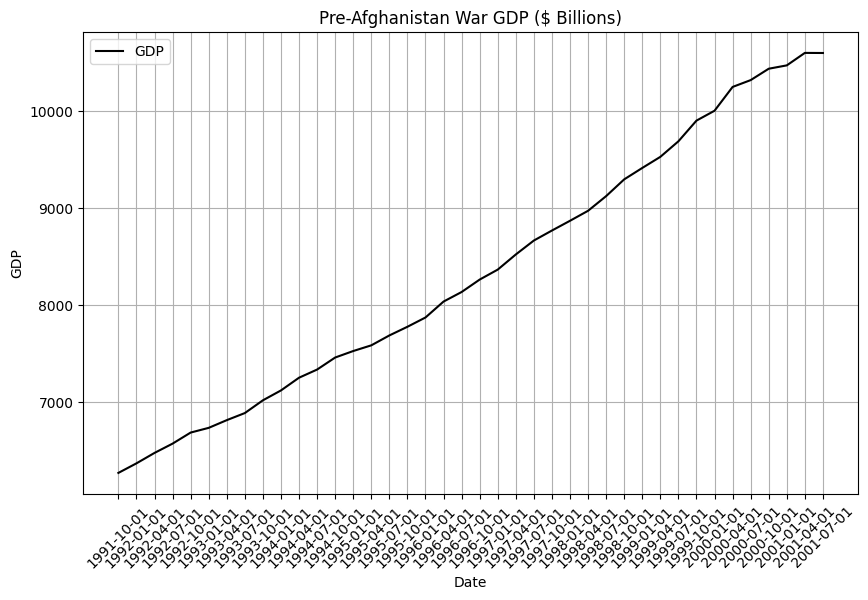

In [ ]:
# Plot Train, Test
plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(PAW_df.DATE, PAW_df.GDP, color='black', label='GDP')
plt.xticks(rotation=45)
plt.title('Pre-Afghanistan War GDP ($ Billions)')
plt.legend()
plt.grid(True)
plt.show()

### Correlation Matrix

In [ ]:
# Correlation Matrix for 'CPI', 'UNRATE', 'INFL'
PAW_df.corr()

,CPI,FEDFUNDS,PSAVERT,REVOLSL,UNRATE,INFL,GFDEBTN,GDP
CPI,1.000000,0.536549,-0.902363,0.994396,-0.927023,-0.107701,0.959046,0.994400
FEDFUNDS,0.536549,1.000000,-0.553975,0.564781,-0.728359,-0.055749,0.622032,0.515552
PSAVERT,-0.902363,-0.553975,1.000000,-0.881268,0.908242,0.052351,-0.910736,-0.896343
REVOLSL,0.994396,0.564781,-0.881268,1.000000,-0.934020,-0.154237,0.962260,0.988914
UNRATE,-0.927023,-0.728359,0.908242,-0.934020,1.000000,0.274155,-0.972627,-0.921977
INFL,-0.107701,-0.055749,0.052351,-0.154237,0.274155,1.000000,-0.283359,-0.107651
GFDEBTN,0.959046,0.622032,-0.910736,0.962260,-0.972627,-0.283359,1.000000,0.942865
GDP,0.994400,0.515552,-0.896343,0.988914,-0.921977,-0.107651,0.942865,1.000000


### Correlogram

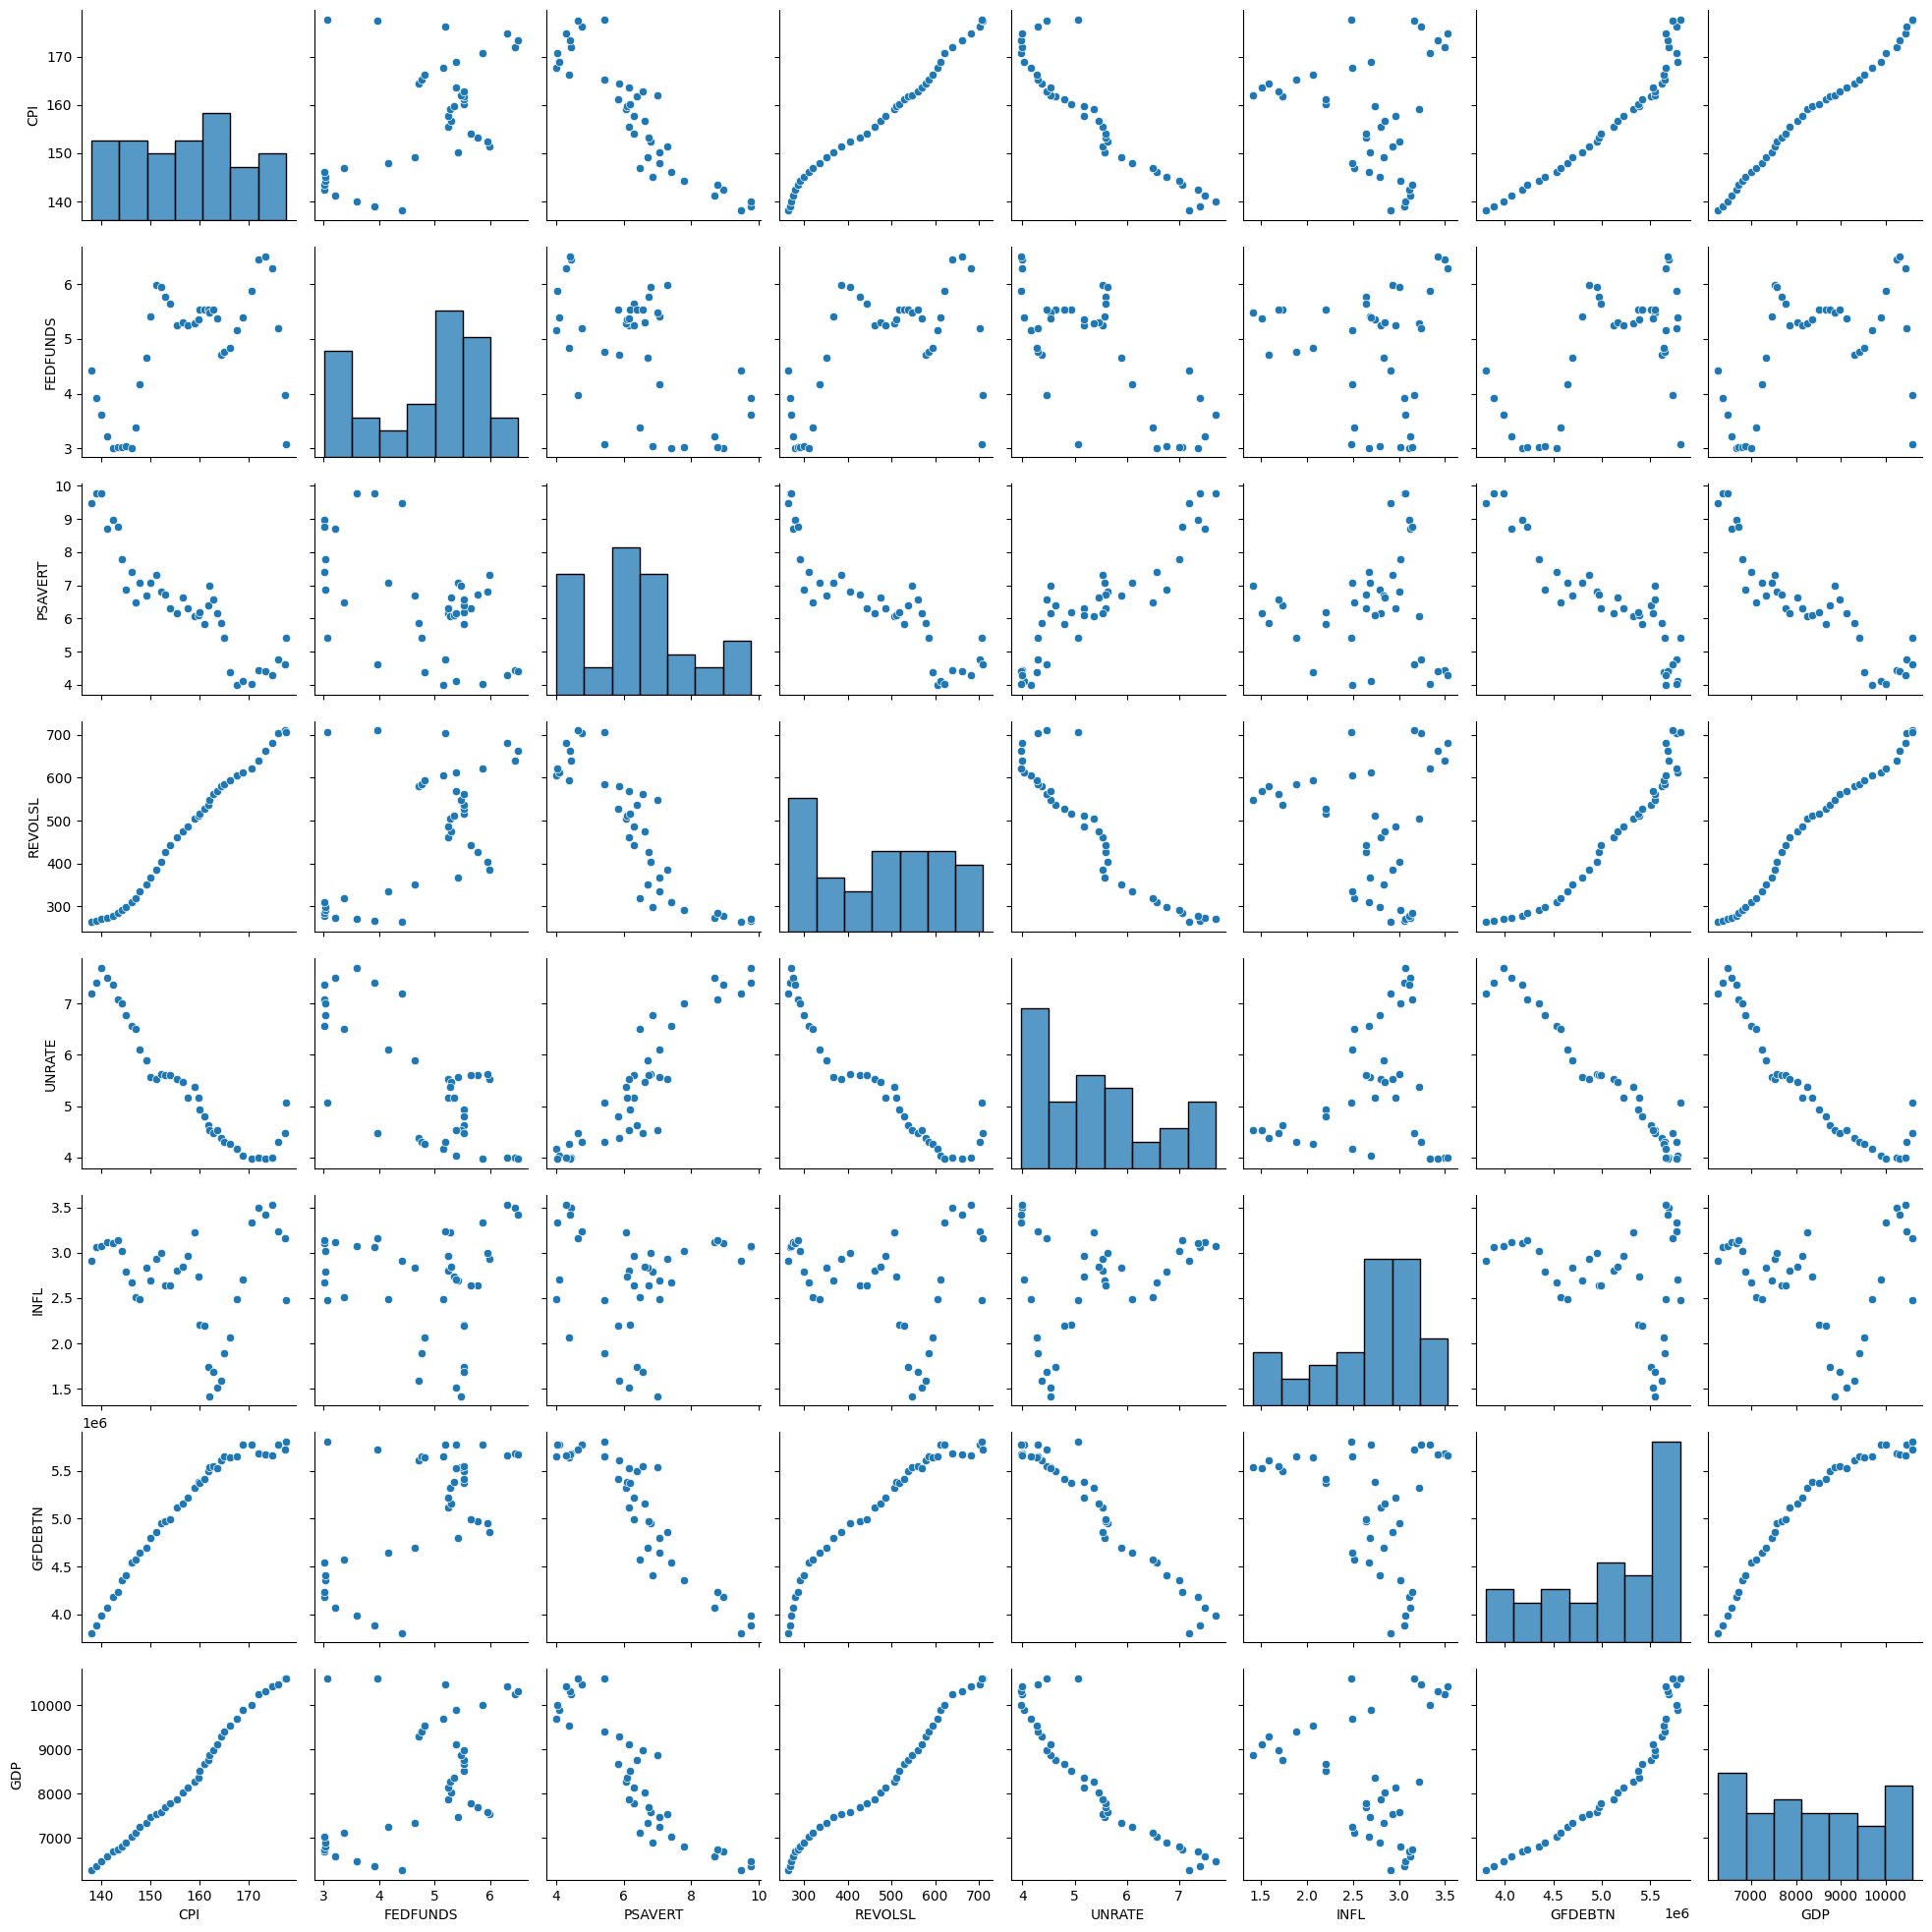

In [ ]:
# Basic correlogram
sns.pairplot(PAW_df)
plt.show()

'CPI', 'PSAVERT', 'REVOLSL', 'UNRATE', 'GFDEBTN' had good correlation values and so we will be using them for this CNN as we have more data from our economic measures available during this time period as opposed to the Vietnam War timeline

### Dataframe for our CNN

In [ ]:
CNN_df = PAW_df[['GDP', 'CPI', 'PSAVERT', 'REVOLSL', 'UNRATE', 'GFDEBTN']]

### Create CNN for Multivariate Multiple Step Sequencing

In [ ]:
def cnn_multivariate_gdp(data, steps_out, seq1, seq2, seq3, seq4, seq5, seq6):
    # define input sequences
    input1 = array(seq1)
    input2 = array(seq2)
    input3 = array(seq3)
    input4 = array(seq4)
    input5 = array(seq5)
    input6 = array(seq6)

    # convert to [rows, columns] structure
    input1 = input1.reshape((len(input1), 1))
    input2 = input2.reshape((len(input2), 1))
    input3 = input3.reshape((len(input3), 1))
    input4 = input4.reshape((len(input4), 1))
    input5 = input5.reshape((len(input5), 1))
    input6 = input6.reshape((len(input6), 1))


    # horizontally stack columns
    dataset = hstack((input1, input2, input3, input4, input5, input6))

    # choose a number of time steps
    n_steps_in, n_steps_out = 3, steps_out

    # convert into input/output
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)

    # flatten output
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))

    # number of features
    n_features = X.shape[2]

    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X, y, epochs=7000, verbose=0)

    # prediction
    x_input = array([[input1[-3],input2[-3],input3[-3],input4[-3],input5[-3],input6[-3]],
    [input1[-2],input2[-2],input3[-2],input4[-2],input5[-2],input6[-2]],
    [input1[-1],input2[-1],input3[-1],input4[-1],input5[-1],input6[-1]]])
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    results = np.array_split(yhat[0],n_steps_out)

    return results


### Predicting GDP for Afghanistan War using a Multivariate CNN

In [ ]:
def CNN_GDP_predictions_afghanistan_war(full_war_df,CNN_df):
    # The total number of GDP entries we want with Pre-War and Predictions combined
    full_war_gdp_length = len(full_war_df)

    # CPI values
    CPI_list = list(CNN_df.CPI)

    # GDP values
    GDP_list = list(CNN_df.GDP)

    # PSAVERT values
    PSAVERT_list = list(CNN_df.PSAVERT)

    # REVOLSL values
    REVOLSL_list = list(CNN_df.REVOLSL)

    # UNRATE values
    UNRATE_list = list(CNN_df.UNRATE)

    # GFDEBTN values
    GFDEBTN_list = list(CNN_df.GFDEBTN)

    # difference between how many entries we want and how many we currently have
    gdp_difference = full_war_gdp_length - len(GDP_list)

    # maximum number of predictions we can generate from our CNN
    max_predictions = (len(GDP_list) - 3)
    
    # continuously make predictions until we have the desired number
    while gdp_difference != 0:
        # determine how many predictions we will be returning from our CNN
        if gdp_difference > max_predictions:
            num_steps = max_predictions
        else:
            num_steps = gdp_difference

        # make predictions
        predictions = cnn_multivariate_gdp(CNN_df,num_steps,CPI_list,PSAVERT_list,
        REVOLSL_list,UNRATE_list,GFDEBTN_list,GDP_list)

        # update our values with the new predictions
        for i in range(len(predictions)):
            CPI_list.append(predictions[i][0])
            PSAVERT_list.append(predictions[i][1])
            REVOLSL_list.append(predictions[i][2])
            UNRATE_list.append(predictions[i][3])
            GFDEBTN_list.append(predictions[i][4])
            GDP_list.append(predictions[i][5])
        
        # keep gdp difference up to date    
        gdp_difference = full_war_gdp_length - len(GDP_list)

    # add our predictions to our full war dataframe
    full_war_df['CPI_Predictions'] = CPI_list
    full_war_df['GDP_Predictions'] = GDP_list
    full_war_df['PSAVERT_Predictions'] = PSAVERT_list
    full_war_df['REVOLSL_Predictions'] = REVOLSL_list
    full_war_df['UNRATE_Predictions'] = UNRATE_list
    full_war_df['GFDEBTN_Predictions'] = GFDEBTN_list
    
    
    return full_war_df

In [ ]:
afghanistan_war_predictions_df = CNN_GDP_predictions_afghanistan_war(aw_aem_df,CNN_df)

### Afghanistan War Actual GDP & CNN Multivariate Predicted GDP

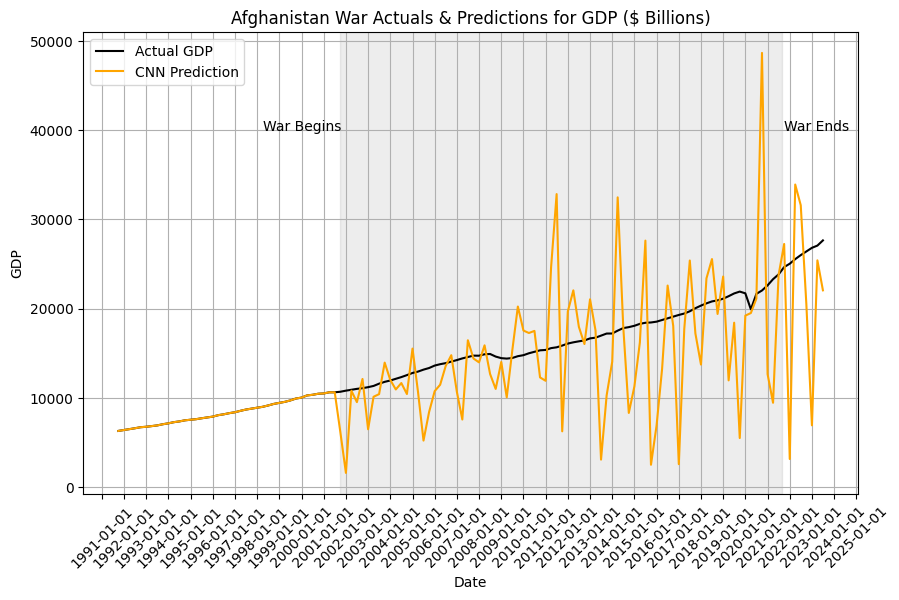

In [ ]:
xdates = [dt.strptime(dstr,'%Y-%m-%d') for dstr in afghanistan_war_predictions_df.DATE]

plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(xdates, afghanistan_war_predictions_df.GDP, color='black', label='Actual GDP')
plt.plot(xdates, afghanistan_war_predictions_df.GDP_Predictions, color='orange', label = 'CNN Prediction')
plt.gca().xaxis.set_major_locator(mdates.YearLocator((1)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.axvspan('2001-09-18', '2021-08-30', color='k', alpha=0.07)
plt.text(xdates[26],40000,'War Begins')
plt.text(xdates[120],40000,'War Ends')
plt.legend()
plt.xticks(rotation=45)
plt.title('Afghanistan War Actuals & Predictions for GDP ($ Billions)')
plt.legend()
plt.grid(True)
plt.show()

### Check Performance with RMSE

In [ ]:
mse = sklearn.metrics.mean_squared_error(afghanistan_war_predictions_df.GDP, 
afghanistan_war_predictions_df.GDP_Predictions)
rmse = math.sqrt(mse)
print(rmse)

6220.558792236831


> The graphed predictions for The Afghanistan War's GDP look more erratic compared to the predicted GDP for The Vietnam War and also have a much higher RMSE score. This is likely due to the fact that we had a more simplistic sequence prediction for The Vietnam War with only 'CPI' and 'GDP' as our variables, due to the lack of Federal Date during that time range, while our model for The Afghanistan War has six variables ('CPI', 'PSAVERT', 'REVOLSL', 'UNRATE',  GFDEBTN', 'GDP'). With the CNN model used for The Afghanistan War we have variables with both positive and negative correlation values, while the CNN model used for The Vietnam War had only a positive correlation. We're going to run a new CNN model for The Afghanistan War using only 'CPI' and 'GDP' to compare to the CNN model used for The Afghanistan War.

### Create CNN for Multivariate (Dual) Multiple Step Sequencing

In [ ]:
def cnn_multivariate_gdp_dual(data, steps_out, sequence1, sequence2):
    # define input sequences
    input1 = array(sequence1)
    input2 = array(sequence2)

    # convert to [rows, columns] structure
    input1 = input1.reshape((len(input1), 1))
    input2 = input2.reshape((len(input2), 1))

    # horizontally stack columns
    dataset = hstack((input1, input2))

    # choose a number of time steps
    n_steps_in, n_steps_out = 3, steps_out

    # convert into input/output
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)

    # flatten output
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))

    # number of features
    n_features = X.shape[2]

    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X, y, epochs=7000, verbose=0)

    # prediction
    x_input = array([[input1[-3],input2[-3]], [input1[-2],input2[-2]], [input1[-1],input2[-1]]])
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    results = np.array_split(yhat[0],n_steps_out)

    return results


### Predicting GDP for Afghanistan War using a Multivariate (Dual) CNN

In [ ]:
def CNN_GDP_predictions_afghanistan_war_dual(full_war_df,CNN_df):
    # The total number of GDP entries we want with Pre-War and Predictions combined
    full_war_gdp_length = len(full_war_df)

    # CPI values
    CPI_list = list(CNN_df.CPI)

    # GDP values
    GDP_list = list(CNN_df.GDP)

    # difference between how many entries we want and how many we currently have
    gdp_difference = full_war_gdp_length - len(GDP_list)

    # maximum number of predictions we can generate from our CNN
    max_predictions = (len(GDP_list) - 3)
    
    # continuously make predictions until we have the desired number
    while gdp_difference != 0:
        # determine how many predictions we will be returning from our CNN
        if gdp_difference > max_predictions:
            num_steps = max_predictions
        else:
            num_steps = gdp_difference

        # make predictions
        predictions = cnn_multivariate_gdp_dual(CNN_df,num_steps,CPI_list,GDP_list)

        # update our values with the new predictions
        for i in range(len(predictions)):
            CPI_list.append(predictions[i][0])
            GDP_list.append(predictions[i][1])
        
        # keep gdp difference up to date    
        gdp_difference = full_war_gdp_length - len(GDP_list)

    # add our predictions to our full war dataframe
    full_war_df['CPI_Predictions'] = CPI_list
    full_war_df['GDP_Predictions'] = GDP_list
    
    
    return full_war_df

In [ ]:
afghanistan_war_predictions_df_dual = CNN_GDP_predictions_afghanistan_war_dual(aw_aem_df,CNN_df)

### Afghanistan War Actual GDP & CNN Multivariate (Dual) Predicted GDP

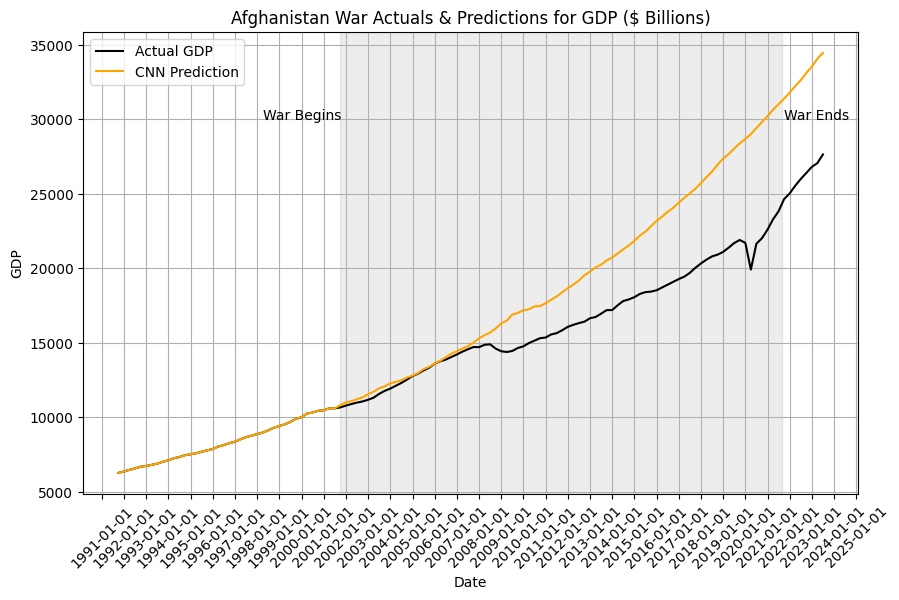

In [ ]:
xdates = [dt.strptime(dstr,'%Y-%m-%d') for dstr in afghanistan_war_predictions_df.DATE]

plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(xdates, afghanistan_war_predictions_df_dual.GDP, color='black', label='Actual GDP')
plt.plot(xdates, afghanistan_war_predictions_df_dual.GDP_Predictions, color='orange', label = 'CNN Prediction')
plt.gca().xaxis.set_major_locator(mdates.YearLocator((1)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.axvspan('2001-09-18', '2021-08-30', color='k', alpha=0.07)
plt.text(xdates[26],30000,'War Begins')
plt.text(xdates[120],30000,'War Ends')
plt.legend()
plt.xticks(rotation=45)
plt.title('Afghanistan War Actuals & Predictions for GDP ($ Billions)')
plt.legend()
plt.grid(True)
plt.show()

### 

### Check Performance with RMSE - Dual Variable CNN

In [ ]:
mse = sklearn.metrics.mean_squared_error(afghanistan_war_predictions_df_dual.GDP, 
afghanistan_war_predictions_df_dual.GDP_Predictions)
rmse_dual = math.sqrt(mse)
print(rmse_dual)

3461.756311983399


### Compare Performance of 6 Variable & 2 Variable CNN Models Using RMSE

In [ ]:
print('Afghanistan War CNN Model Comparison')
print('Multivariate CNN Model with 6 variables RMSE:',rmse)
print('Multivariate CNN Model with 2 variables RMSE:',rmse_dual)

Afghanistan War CNN Model Comparison
Multivariate CNN Model with 6 variables RMSE: 6220.558792236831
Multivariate CNN Model with 2 variables RMSE: 3461.756311983399


> When comparing the two models for The Afghanistan War we can see that the dual variable model scored almost half of the six variable model in RMSE. The graph also shows a more smooth prediction line, however, because the sequencing was learned during a time where GDP only climbed, the model assumed that GDP would only continue to rise and not fall. In reality, we can see that GDP does take a few dips even during an active war time.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ba1e4b21-f3e5-4d67-887d-75e6f1b74e8f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>